## With & without immune decay

In [1]:
import pfTent as tent
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Make graphs to plot a few trajectories, one in detail, a couple broadly, and then all the outputs

In [2]:
y=3
a = [10,10,10,10,10,10]
w = [0,1/5,1/5,1/5,1/5,1/5]
eir=40
n_people = 100
immune_loci = len(a)-1

In [43]:
all_parasites, all_immunity, all_strains, all_malaria, all_infections = tent.simulate_cohort(n_people,y,a,w,t12=100,xh=0.5,immune_thresh=0.01)

In [7]:
def overall_outcomes(all_parasites,all_strains,all_malaria,n_people,y):
    '''
    Generates distribution of parasite densities, infection_lengths, MOI, % parasitemia, malaria for all.
    '''
    all_parasite_density = []
    all_infection_lengths = []
    all_MOI = []
    all_percent_parasitemia = []
    all_malaria_rate = []

    for person in range(n_people):

        Parasitemia, perPositivity = tent.check_parasitemia(3,all_parasites[person,...])
        MOI = tent.check_moi(3,all_strains[person])
        infectionlengths = tent.check_infection_length(all_strains[person],y,all_malaria[person])
        malaria_per_year = len(all_malaria[person])/y

        all_parasite_density.extend(Parasitemia)
        all_infection_lengths.extend(infectionlengths)
        all_MOI.extend(MOI)
        all_percent_parasitemia.append(perPositivity)
        all_malaria_rate.append(malaria_per_year)
    
    return all_parasite_density, all_infection_lengths, all_MOI, all_percent_parasitemia, all_malaria_rate

In [8]:
def graph_pop(all_parasites,all_strains,all_malaria,output=None):
    n_people = len(all_parasites)
    y = int(all_parasites.shape[-1]/365)
    pdens,ilength,moi,prev,mal = overall_outcomes(all_parasites,all_strains,all_malaria,n_people,y)
    pdens = np.asarray(pdens)
    logPdensity = np.log10(pdens[pdens != 0])
    
    fig,ax = plt.subplots(nrows = 5, tight_layout=True, figsize=(12,15))
    ax[0].hist(logPdensity, bins=30, edgecolor = "black")
    ax[0].set_xlabel('log10 parasite density (parasites/uL)')
    #ax[0].set_yscale('log')
    #ax[0].set_xscale('log')
    ax[1].hist(ilength, bins=50, edgecolor = "black")
    ax[1].set_xlabel('Infection length')
    ax[2].hist(moi, bins=(max(moi)+1), edgecolor = "black")
    ax[2].set_xlabel('Multiplicity of infection')
    ax[3].hist(prev, bins=10, edgecolor = "black")
    ax[3].set_xlabel('Prevalence')
    ax[4].hist(mal, bins=9, edgecolor = "black")
    ax[4].set_xlabel('Malaria cases per year')

    if output:
        fig.savefig(output)

    results = [logPdensity, ilength,moi, prev, mal]
    labels = ['Parasite density', 'Infection length', 'MOI', '% Parasitemia', 'Malaria cases per year']

    for values, l in zip(results, labels):
        print(l)
        print('min:' + str(min(values)))
        print('max:' + str(max(values)))
        print('median:' + str(np.median(values)))
        print('mean:' + str(np.average(values)))
        print('std:' + str(np.std(values)))
        print('---------------------')

In [9]:
def graph_trajectories(n,all_parasites,output=None):
    '''
    Graphs overall pdens trajectories n individuals in the cohort.
    '''
    n_people = len(all_parasites)
    spacing = int(n_people/n)
    
    height = 4*n
    fig, ax = plt.subplots(nrows=n,tight_layout=True, figsize=(14,height))
    for i,person in enumerate(range(5,n_people,spacing)):
        ax[i].tick_params(axis='both', which='major', labelsize=14)
        ax[i].set_yscale('log')
        ax[i].plot(np.arange(y*365)/365, all_parasites[person,-1,:,:].sum(axis=0),color="black")

        ax[i].set_ylim(0.001,3000000)
        ax[i].set_title('person ' + str(person),fontsize=18)
        ax[i].set_xlabel('Years',fontsize=16)
        ax[i].set_ylabel('Parasites/uL',fontsize=16)
    if output:
        fig.savefig(output)

In [10]:
def graph_individual(a,locus,pmatrix,imatrix,output=None):
    '''
    Graphs overall parasite density & pdensity & immunity at each allele of a locus.
    '''
    alleles = a[locus]
    y = int(pmatrix.shape[-1]/365)
    colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

    height=3*(2+alleles)
    fig, ax = plt.subplots(nrows=2+alleles, sharey=True, sharex=True, tight_layout=True, figsize=(14,height))
    ax[0].tick_params(axis='both', which='major', labelsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=14)
    ax[0].set_yscale('log')
    ax[0].plot(np.arange(y*365)/365, pmatrix[locus,:,:].sum(axis=0),color="black")
    for strain in np.arange(alleles):
        iStrain = pmatrix[locus,strain,:]
        if np.sum(iStrain) > 1:
            ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
    ax[0].set_ylim(0.001,3000000)
    ax[1+alleles].set_xlabel('Years',fontsize=16)
    ax[0].set_ylabel('Parasites/uL)',fontsize=16)
    ax[0].set_title('Total parasite density')
    ax[1].set_title('Parasite density colored by allele at test locus')
    ax[1].set_ylabel('Parasites/uL)',fontsize=16)
    for row in range(2,2+alleles):
        ax[row].tick_params(axis='both', which='major', labelsize=14)
        ax[row].set_ylabel('Parasites/uL)',fontsize=16)
        other = [strain for strain in range(0,5) if strain != row-2]
        ax[row].plot(np.arange(y*365)/365, pmatrix[locus,row-2,:],linewidth=3,color=colors[row-2])
        ax2 = ax[row].twinx()
        ax2.set_ylabel('Strain immunity',fontsize=16)
        ax2.plot(np.arange(y*365)/365, imatrix[locus,row-2,:],linewidth=1.5,color='black',linestyle='dashed')
        
    if output:
        fig.savefig(output)

In [25]:
def check_outcomes(a,locus,all_parasites,all_strains,all_malaria,output=None):
    '''
    Produces graphs for simulations.
    '''
    if output:
        output_p = output + "_pop.pdf"
        output_t = output + "_trajectory.pdf"
        output_i = output + "_individual.pdf"
    else:
        output_p = None
        output_t = None
        output_i = None
    graph_pop(all_parasites,all_strains,all_malaria,output=output_p)
    graph_trajectories(5,all_parasites,output=output_t)
    graph_individual(a,locus,all_parasites[-1,...],all_immunity[-1,...],output=output_i)

Parasite density
min:-1.832834095803191
max:4.706246076854298
median:1.7073258741074628
mean:1.7278447112576067
std:0.9189621765571792
---------------------
Infection length
min:1
max:353
median:89.0
mean:100.86154023518561
std:64.16665268133626
---------------------
MOI
min:0
max:19
median:9.0
mean:8.122972972972972
std:4.468902982179676
---------------------
% Parasitemia
min:0.7567567567567568
max:0.972972972972973
median:0.8918918918918919
mean:0.8970270270270269
std:0.04738524641482843
---------------------
Malaria cases per year
min:0.6666666666666666
max:3.3333333333333335
median:1.8333333333333335
mean:1.8533333333333335
std:0.5319147801418318
---------------------


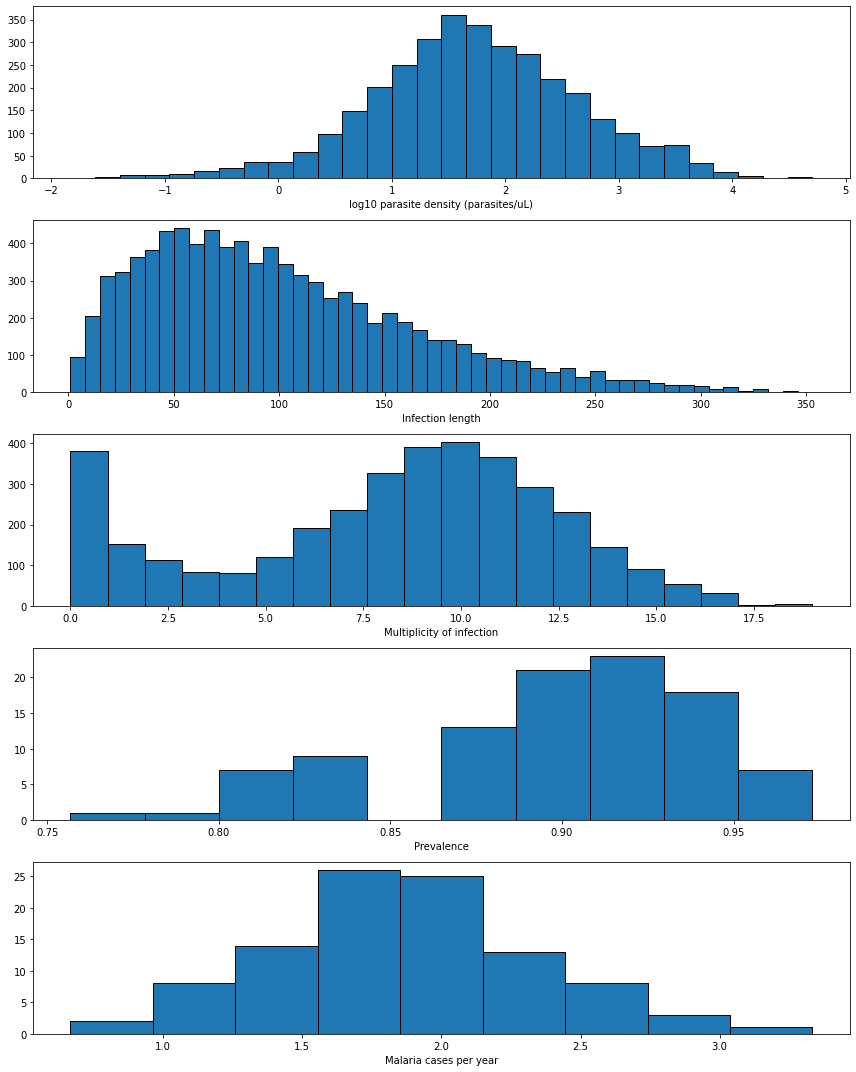

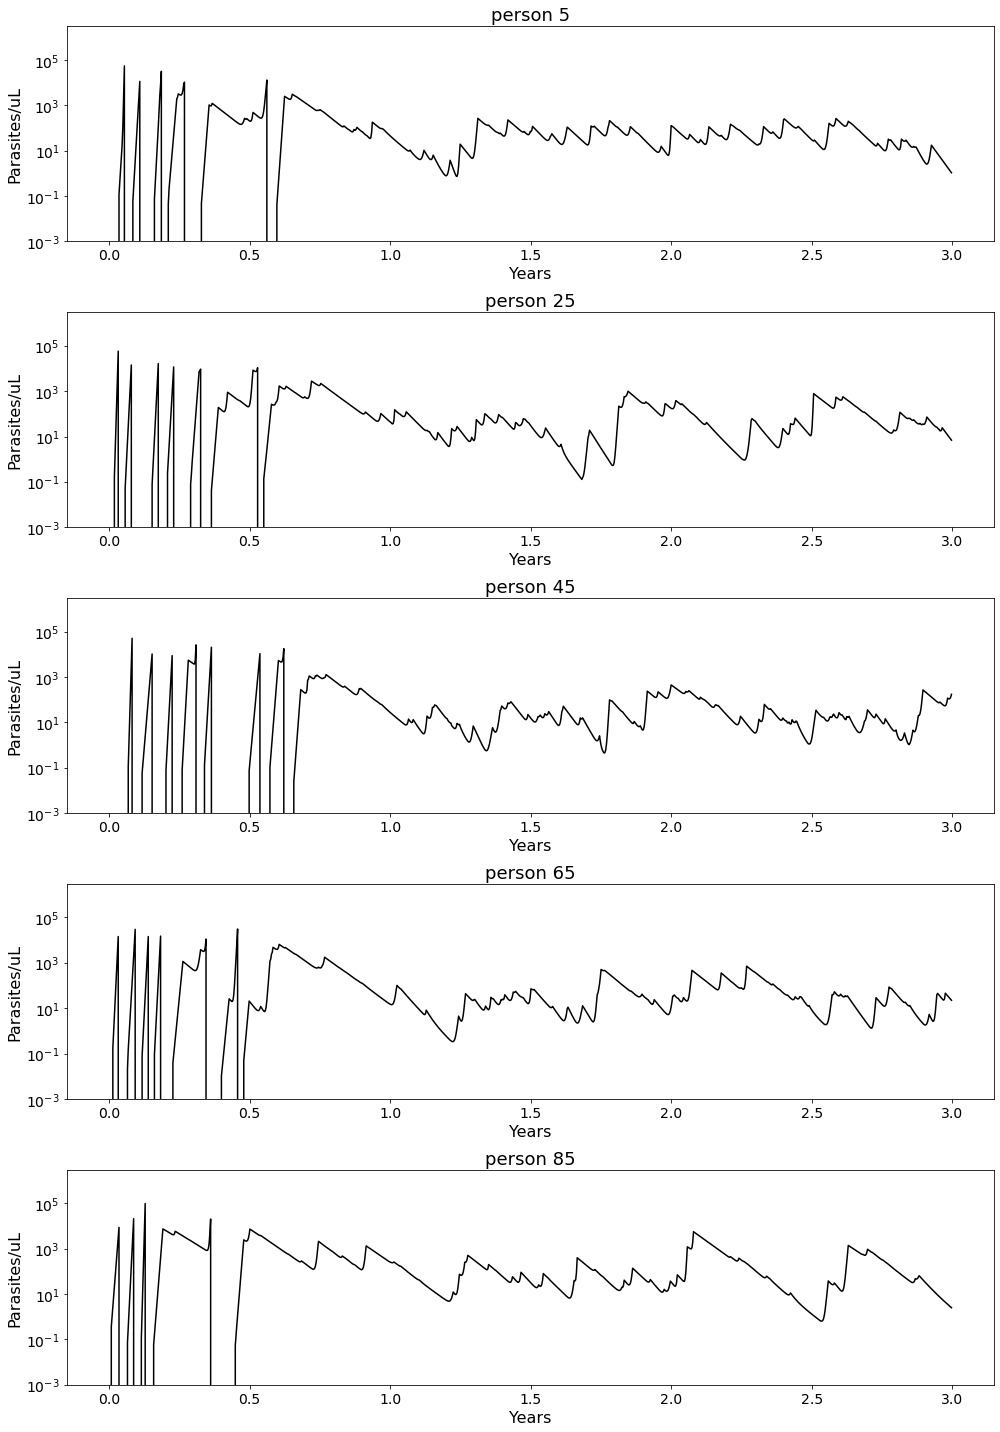

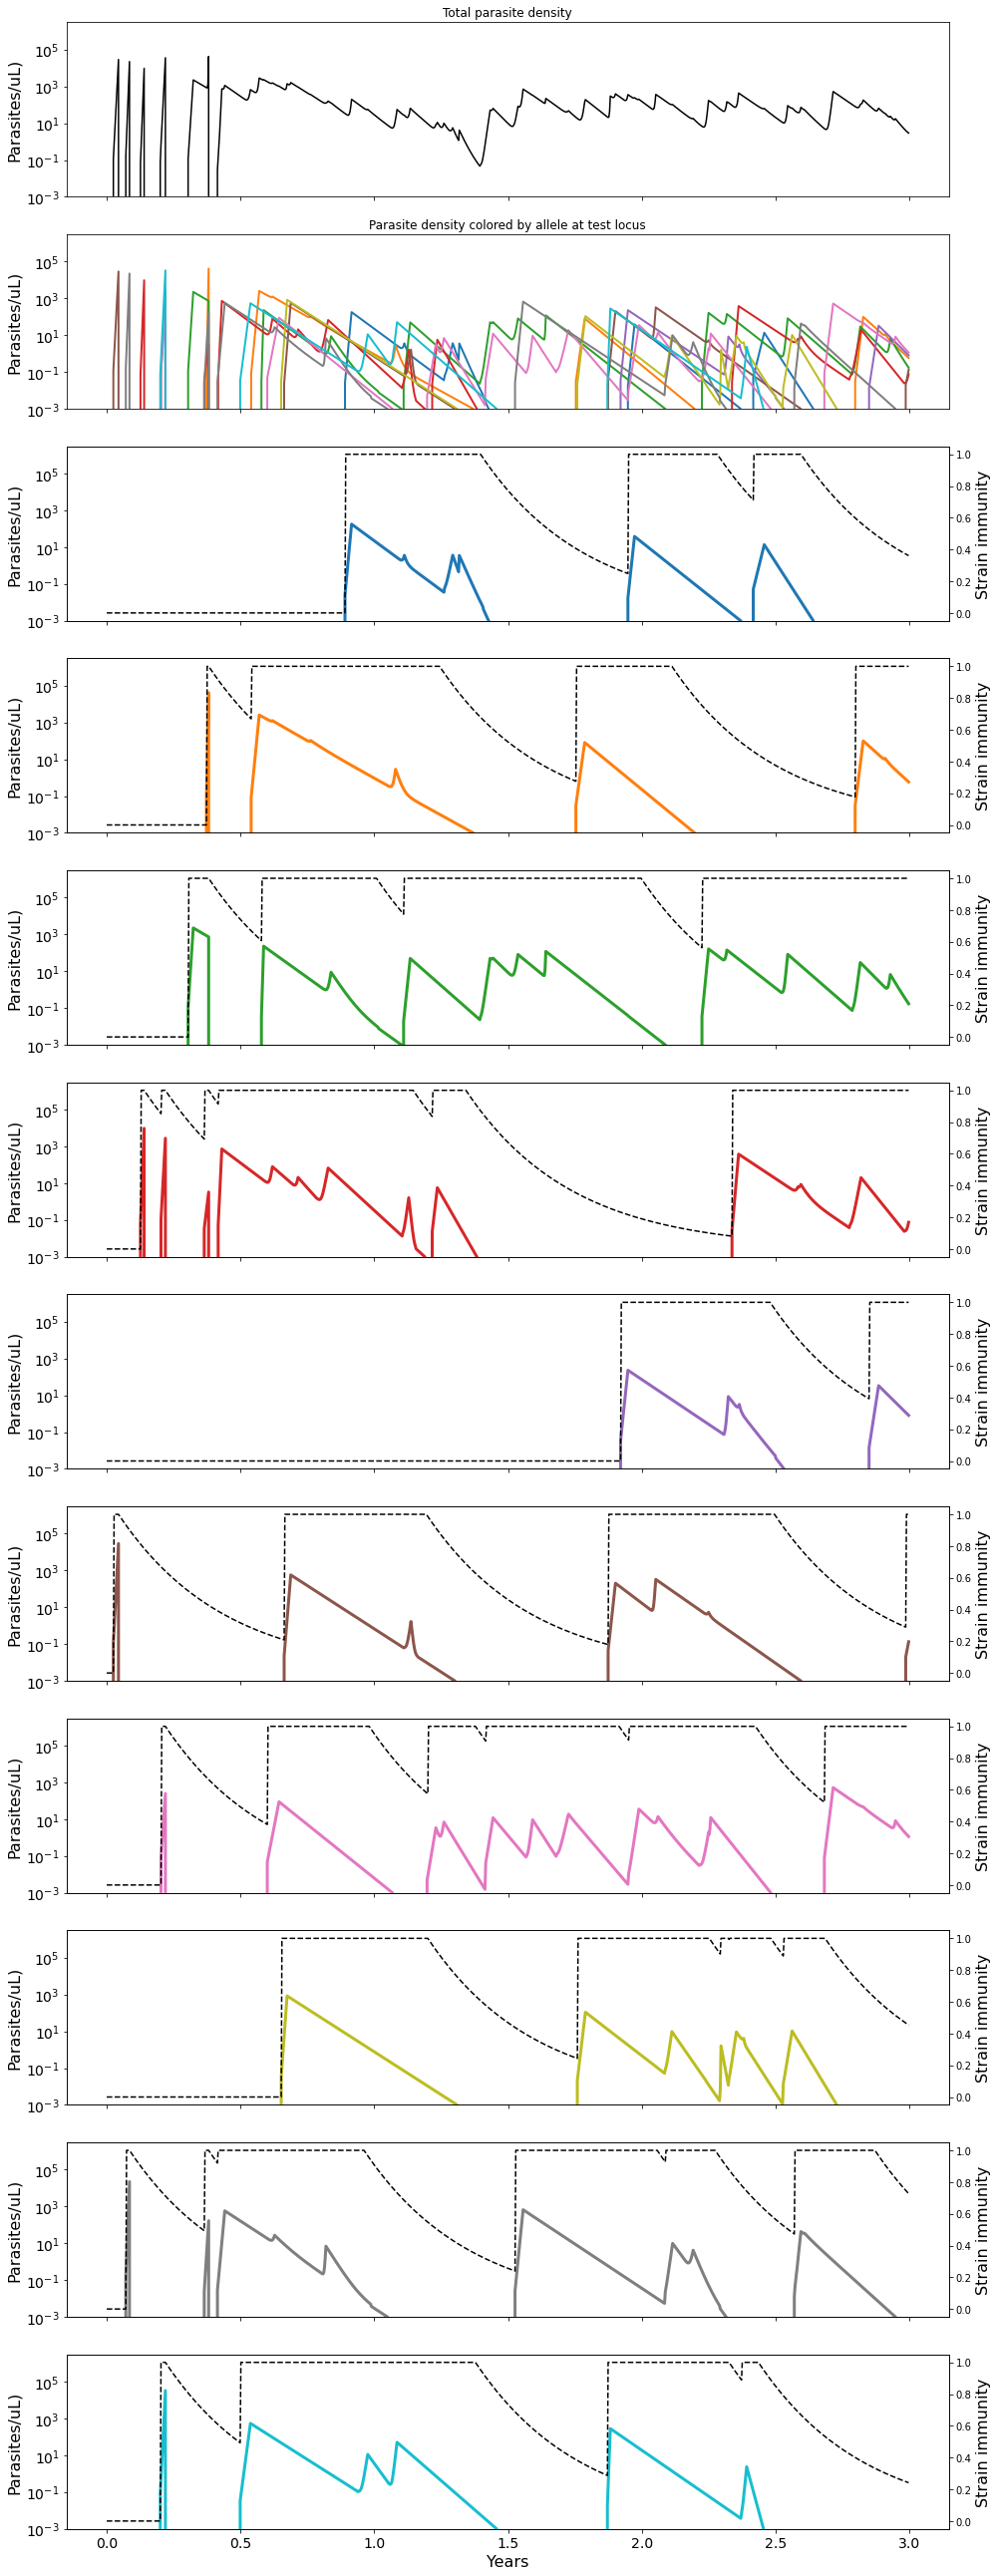

In [44]:
check_outcomes(a,5,all_parasites,all_strains,all_malaria)